In [1]:
!pip install tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [7]:
pip install numpy==1.26.4


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
!pip install seaborn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [13]:
pip install tensorflow

  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached namex-0.1.0-py3-none-any.whl.metadata (322 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 MB 14.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 15.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [47]:
# Using Python 3.10 and compatible package versions to avoid issues with NumPy and library incompatibilities.
# Importing the Libraries
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import glob
from tqdm import tqdm
import gc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, RepeatVector
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from collections import defaultdict
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, BatchNormalization, TimeDistributed
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from collections import Counter
import matplotlib.image as mpimg

In [24]:
# Define the paths to the images and labels folders
images_root = '/Users/nadeembaqaeen/Desktop/MSc Project/Annotations/Pain_Dataset_Images'
pspi_labels_root = '/Users/nadeembaqaeen/Desktop/MSc Project/Annotations/Frame_Labels/PSPI'

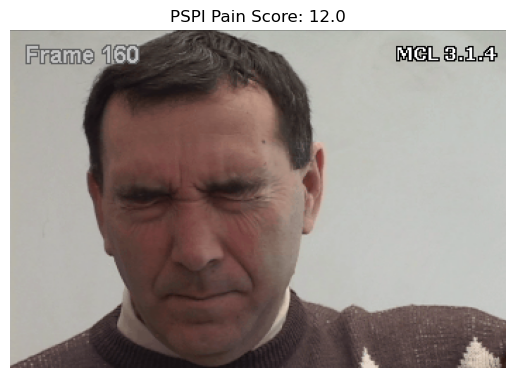

In [25]:
# Define a sample subject, sequence, and image filename
subject_id = '064-ak064'
sequence_id = 'ak064t1aaaff'
image_filename = 'ak064t1aaaff160.png'

# Build the full image path
image_path = os.path.join(images_root, subject_id, sequence_id, image_filename)

# Build the corresponding PSPI label file path
label_filename = image_filename.replace('.png', '_facs.txt')
label_path = os.path.join(pspi_labels_root, subject_id, sequence_id, label_filename)

# Load the image
image = Image.open(image_path)

# Read the PSPI score (stored as a single number in the label file)
with open(label_path, 'r') as file:
    pspi_score = float(file.readline().strip())

# Display the image and its PSPI pain score
plt.imshow(image)
plt.axis('off')
plt.title(f'PSPI Pain Score: {pspi_score}')
plt.show()

In [26]:
# Collect all .png image paths recursively
image_paths = glob.glob(os.path.join(images_root, '**', '*.png'), recursive=True)

print(f'Total images found: {len(image_paths)}')

# Create a list to store image paths and their corresponding PSPI labels
image_label_pairs = []

for img_path in image_paths:
    # Extract relative path parts
    rel_path = os.path.relpath(img_path, images_root)
    subject_id, sequence_id, filename = rel_path.split(os.sep)

    # Construct PSPI label path
    label_filename = filename.replace('.png', '_facs.txt')
    label_path = os.path.join(pspi_labels_root, subject_id, sequence_id, label_filename)

    # Some frames might not have labels — skip if missing
    if not os.path.exists(label_path):
        continue

    # Read the PSPI pain score
    with open(label_path, 'r') as file:
        try:
            pspi_score = float(file.readline().strip())
        except:
            continue  # Skip if label file is empty or invalid

    # Append to dataset list
    image_label_pairs.append((img_path, pspi_score))

# Preview the first 5
for path, score in image_label_pairs[:5]:
    print(f'{path} --> PSPI: {score}')

print(f'\nTotal labeled image samples collected: {len(image_label_pairs)}')


Total images found: 48398
/Users/nadeembaqaeen/Desktop/MSc Project/Annotations/Pain_Dataset_Images/064-ak064/ak064t1aaaff/ak064t1aaaff060.png --> PSPI: 0.0
/Users/nadeembaqaeen/Desktop/MSc Project/Annotations/Pain_Dataset_Images/064-ak064/ak064t1aaaff/ak064t1aaaff074.png --> PSPI: 0.0
/Users/nadeembaqaeen/Desktop/MSc Project/Annotations/Pain_Dataset_Images/064-ak064/ak064t1aaaff/ak064t1aaaff048.png --> PSPI: 0.0
/Users/nadeembaqaeen/Desktop/MSc Project/Annotations/Pain_Dataset_Images/064-ak064/ak064t1aaaff/ak064t1aaaff262.png --> PSPI: 0.0
/Users/nadeembaqaeen/Desktop/MSc Project/Annotations/Pain_Dataset_Images/064-ak064/ak064t1aaaff/ak064t1aaaff276.png --> PSPI: 0.0

Total labeled image samples collected: 48398


In [27]:
# Set desired image size
image_size = (128, 128)

# Arrays to hold image data and labels
X = []
y = []

# Loop over all image-label pairs and process
for img_path, label in tqdm(image_label_pairs[:3000]):  # Limit to 3000 samples for faster testing
    try:
        # Open and resize image
        img = Image.open(img_path).convert('L')  # convert to grayscale
        img = img.resize(image_size)

        # Convert to numpy array and normalize
        img_array = np.array(img) / 255.0

        X.append(img_array)
        y.append(label)
    except Exception as e:
        print(f"Failed to process {img_path}: {e}")

# Convert to numpy arrays
X = np.array(X).reshape(-1, image_size[0], image_size[1], 1)  # Add channel dimension
y = np.array(y)
print(f'X shape: {X.shape}, y shape: {y.shape}')

100%|██████████████████████████████████████| 3000/3000 [00:06<00:00, 482.60it/s]


X shape: (3000, 128, 128, 1), y shape: (3000,)


In [28]:
# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f'Training samples: {len(X_train)}, Testing samples: {len(X_test)}')

Training samples: 2400, Testing samples: 600


In [29]:
# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1)  # Regression output: 1 value (PSPI score)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print summary
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,089 (12.61 MB)

 Trainable params: 3,304,641 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [37]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - loss: 27.1325 - mae: 1.7346 - val_loss: 6.6411 - val_mae: 2.4103
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - loss: 2.3749 - mae: 0.4611 - val_loss: 14.6221 - val_mae: 3.7458
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 2.4254 - mae: 0.4347 - val_loss: 22.7580 - val_mae: 4.6883
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - loss: 2.3595 - mae: 0.4240 - val_loss: 19.5034 - val_mae: 4.2505
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - loss: 2.0758 - mae: 0.3931 - val_loss: 12.4523 - val_mae: 3.1543
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - loss: 1.8858 - mae: 0.3618 - val_loss: 5.6857 - val_mae: 1.7518
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - loss: 1.7141 - mae: 0.3343 - val_loss: 2.6217 - val_mae: 0.8258
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - loss: 1.7217 - mae: 0.3400 - val_loss: 2.4724 - val_mae: 0.6391
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 1

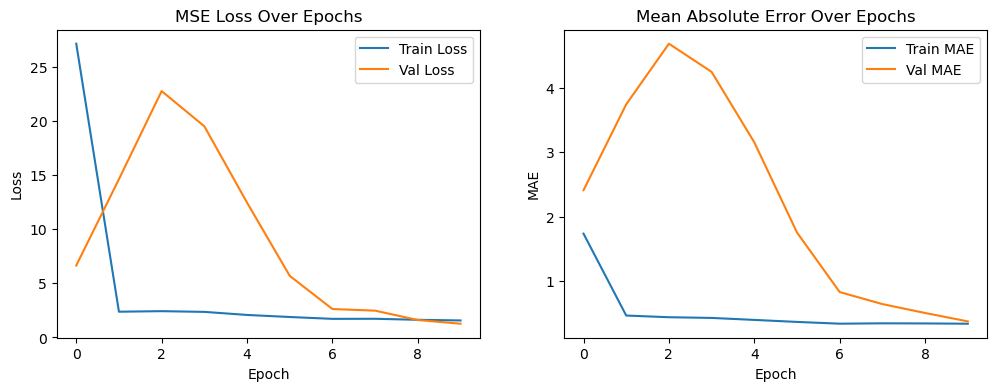

In [43]:
#visualizing the training progress by plotting the model's loss (MSE) and mean absolute error (MAE)
# for both training and validation sets across all epochs to help assess model performance and detect overfitting.
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('MSE Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

In [45]:
# Predict on test set
# Calculate evaluation metrics
y_pred = model.predict(X_test).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score: {r2:.4f}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Mean Squared Error (MSE): 1.2651
Mean Absolute Error (MAE): 0.3702
R² Score: 0.5804


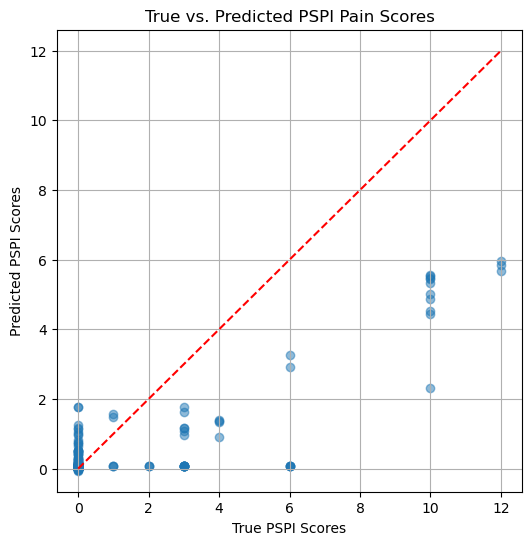

In [47]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Ideal line
plt.xlabel('True PSPI Scores')
plt.ylabel('Predicted PSPI Scores')
plt.title('True vs. Predicted PSPI Pain Scores')
plt.grid(True)
plt.show()

In [49]:
def pspi_to_class(score):
    if score == 0:
        return 0  # No Pain
    elif score <= 4:
        return 1  # Mild
    elif score <= 8:
        return 2  # Moderate
    elif score <= 12:
        return 3  # Intense
    else:
        return 4  # Severe

In [51]:
# Convert true and predicted scores to classes
y_true = np.array([pspi_to_class(s) for s in y_test])
y_pred_scores = model.predict(X_test).flatten()
y_pred = np.array([pspi_to_class(s) for s in y_pred_scores])

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [53]:
aam_root = '/Users/nadeembaqaeen/Desktop/MSc Project/Annotations/AAM_landmarks'

# Create AAM landmark path
rel_path = os.path.relpath(img_path, images_root)
subject_id, sequence_id, filename = rel_path.split(os.sep)

aam_filename = filename.replace('.png', '_aam.txt')
aam_path = os.path.join(aam_root, subject_id, sequence_id, aam_filename)

with open(aam_path, 'r') as f:
    coords = np.loadtxt(f)  # shape: (66, 2)
    coords = coords.flatten()  # shape: (132,)

In [55]:
# Printing the results of the model
print(classification_report(
    y_true, y_pred,
    labels=[0, 1, 2, 3, 4],
    target_names=["No Pain", "Mild", "Moderate", "Intense", "Severe"]
))

              precision    recall  f1-score   support

     No Pain       0.00      0.00      0.00       551
        Mild       0.05      1.00      0.09        29
    Moderate       0.00      0.00      0.00         7
     Intense       0.00      0.00      0.00        13
      Severe       0.00      0.00      0.00         0

    accuracy                           0.05       600
   macro avg       0.01      0.20      0.02       600
weighted avg       0.00      0.05      0.00       600



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pac

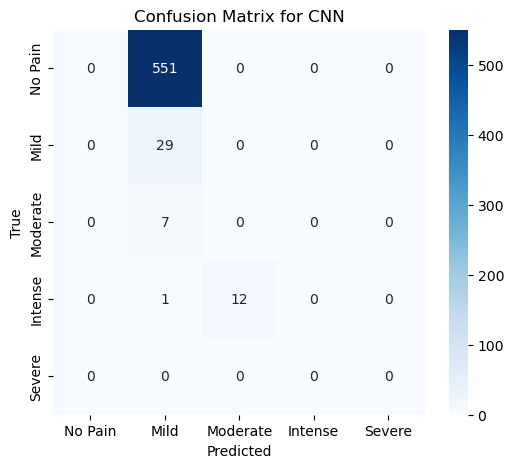

In [57]:
# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])

# Plot with correct labels for 5 classes
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=["No Pain", "Mild", "Moderate", "Intense", "Severe"],
            yticklabels=["No Pain", "Mild", "Moderate", "Intense", "Severe"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CNN')
plt.show()

# CNN + LSTM

In [60]:
# Number of frames per sequence set to 10
sequence_length = 10
image_size = (128, 128)

In [62]:
# Group frames by sequence
# Sort frames by filename (to keep temporal order)
sequence_dict = defaultdict(list)
for img_path, label in image_label_pairs:
    rel_path = os.path.relpath(img_path, images_root)
    subject_id, sequence_id, filename = rel_path.split(os.sep)
    seq_key = f"{subject_id}/{sequence_id}"
    sequence_dict[seq_key].append((img_path, label))

for key in sequence_dict:
    sequence_dict[key] = sorted(sequence_dict[key], key=lambda x: x[0])

In [64]:
X_seq = []
y_seq = []

max_sequences = 500  # adjust as needed based on RAM

count = 0
for seq in list(sequence_dict.values()):
    if len(seq) < sequence_length:
        continue
    for i in range(len(seq) - sequence_length + 1):
        if count >= max_sequences:
            break
        frames = seq[i:i+sequence_length]
        imgs = []
        labels = []
        try:
            for img_path, label in frames:
                img = Image.open(img_path).convert('L').resize(image_size)
                img_array = np.array(img) / 255.0
                imgs.append(img_array)
                labels.append(label)
        except:
            continue

        if len(imgs) == sequence_length:
            X_seq.append(np.array(imgs).reshape(sequence_length, 128, 128, 1))
            y_seq.append(pspi_to_class(labels[-1]))
            count += 1
    if count >= max_sequences:
        break

print(f"Loaded {len(X_seq)} sequences")

Loaded 500 sequences


In [65]:
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print(f'X_seq shape: {X_seq.shape}, y_seq shape: {y_seq.shape}')

X_seq shape: (500, 10, 128, 128, 1), y_seq shape: (500,)


In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 400, Testing samples: 100


In [70]:
# Define CNN block for frame-level feature extraction
# Input shape: (sequence_length, 128, 128, 1)
def build_cnn_block(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Flatten()
    ])
    return model
    
frame_shape = (128, 128, 1)
sequence_length = X_seq.shape[1]

input_layer = Input(shape=(sequence_length, *frame_shape))
cnn = build_cnn_block(frame_shape)
x = TimeDistributed(cnn)(input_layer)
x = LSTM(64)(x)
x = Dense(64, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 128, 128,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 57600)      │        19,200 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │    14,762,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,785,860 (56.40 MB)

 Trainable params: 14,785,668 (56.40 MB)

 Non-trainable params: 192 (768.00 B)

In [72]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=16
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 565ms/step - accuracy: 0.8425 - loss: 0.5852 - val_accuracy: 0.8700 - val_loss: 0.5062
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 560ms/step - accuracy: 0.8675 - loss: 0.4870 - val_accuracy: 0.8700 - val_loss: 0.4745
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 649ms/step - accuracy: 0.8675 - loss: 0.4822 - val_accuracy: 0.8700 - val_loss: 0.4874
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 629ms/step - accuracy: 0.8675 - loss: 0.4885 - val_accuracy: 0.8700 - val_loss: 0.4779
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 802ms/step - accuracy: 0.8675 - loss: 0.4710 - val_accuracy: 0.8700 - val_loss: 0.4676
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8675 - loss: 0.4535 - val_accuracy: 0.8700 - val_loss: 0.4509
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 992ms/step - accuracy: 0.8675 - loss: 0.4522 - val_accuracy: 0.8700 - val_loss: 0.4731
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 925ms/step - accuracy: 0.8675 - loss: 0.4506 - val_accurac

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step
              precision    recall  f1-score   support

     No Pain       0.87      1.00      0.93        87
        Mild       0.00      0.00      0.00         4
    Moderate       0.00      0.00      0.00         2
     Intense       0.00      0.00      0.00         7
      Severe       0.00      0.00      0.00         0

    accuracy                           0.87       100
   macro avg       0.17      0.20      0.19       100
weighted avg       0.76      0.87      0.81       100



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pac

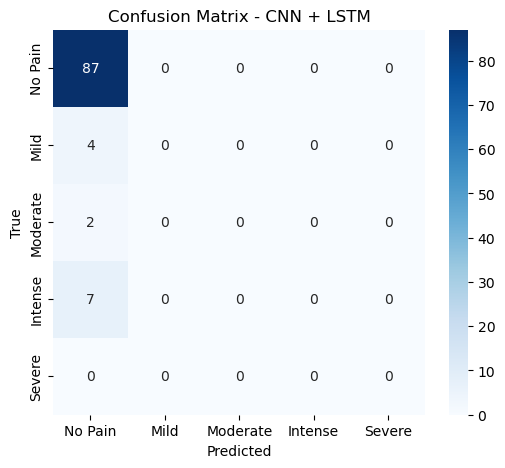

In [75]:
# Classification report and confusion matrix for the results of the model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Updated classification report with 5 target names
print(classification_report(
    y_test, y_pred,
    labels=[0, 1, 2, 3, 4],
    target_names=["No Pain", "Mild", "Moderate", "Intense", "Severe"]
))

# Updated confusion matrix with 5-class labels
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=["No Pain", "Mild", "Moderate", "Intense", "Severe"],
            yticklabels=["No Pain", "Mild", "Moderate", "Intense", "Severe"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CNN + LSTM')
plt.show()

# ResNet + LSTM

In [17]:
# load pretrained ResNet50 without top layer
resnet_base = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)  # ResNet requires 3 channels
)

# Freeze layers (optional)
for layer in resnet_base.layers:
    layer.trainable = False

In [80]:
# wrap ResNet in a feature extractor model
# input for a single frame
frame_input = Input(shape=(128, 128, 3))
x = preprocess_input(frame_input)
x = resnet_base(x)
x = GlobalAveragePooling2D()(x)
resnet_feature_extractor = Model(inputs=frame_input, outputs=x)

In [82]:
# Prepare data with RGB frames
X_seq = []
y_seq = []
max_sequences = 500  # control RAM usage

count = 0
for seq in list(sequence_dict.values()):
    if len(seq) < sequence_length:
        continue
    for i in range(len(seq) - sequence_length + 1):
        if count >= max_sequences:
            break
        frames = seq[i:i+sequence_length]
        imgs = []
        labels = []
        try:
            for img_path, label in frames:
                img = Image.open(img_path).convert('RGB').resize(image_size)
                img_array = np.array(img)
                imgs.append(img_array)
                labels.append(label)
        except:
            continue

        if len(imgs) == sequence_length:
            X_seq.append(np.array(imgs))  # shape: (10, 128, 128, 3)
            y_seq.append(pspi_to_class(labels[-1]))
            count += 1
    if count >= max_sequences:
        break

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
print(f"X_seq shape: {X_seq.shape}, y_seq shape: {y_seq.shape}")

X_seq shape: (500, 10, 128, 128, 3), y_seq shape: (500,)


In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

In [86]:
sequence_input = Input(shape=(sequence_length, 128, 128, 3))
x = TimeDistributed(resnet_feature_extractor)(sequence_input)
x = LSTM(64)(x)
x = Dense(64, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=sequence_input, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 10, 128, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 2048)       │    23,587,712 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,133,060 (92.06 MB)

 Trainable params: 545,348 (2.08 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [88]:
# training the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=16
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8650 - loss: 0.5455 - val_accuracy: 0.8700 - val_loss: 0.4755
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8675 - loss: 0.4357 - val_accuracy: 0.8700 - val_loss: 0.3919
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8675 - loss: 0.3528 - val_accuracy: 0.8700 - val_loss: 0.2963
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9100 - loss: 0.2835 - val_accuracy: 0.9300 - val_loss: 0.2427
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9325 - loss: 0.2244 - val_accuracy: 0.9400 - val_loss: 0.2025
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9375 - loss: 0.1818 - val_accuracy: 0.9300 - val_loss: 0.2178
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9325 - loss: 0.1653 - val_accuracy: 0.9400 - val_loss: 0.1308
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9425 - loss: 0.1437 - val_accuracy: 0.9500 - val_loss:

3/4 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepWARNING:tensorflow:5 out of the last 28 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x35e49b060> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step
              precision    recall  f1-score   support

     No Pain       1.00      1.00      1.00        87
        Mild       1.00      0.50      0.67         4
    Moderate       1.00      1.00      1.00  

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pac

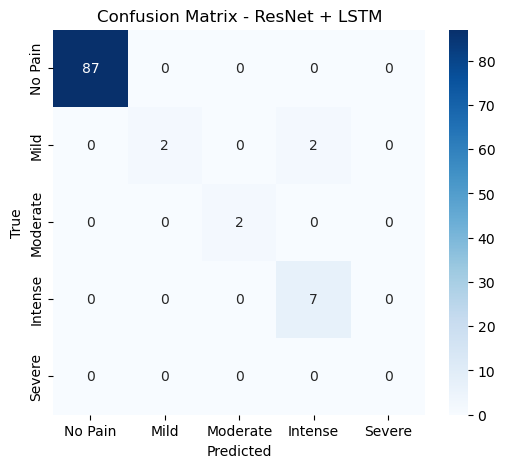

In [90]:
# Evaluate the model's performance
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report for 5-class pain categories
print(classification_report(
    y_test, y_pred,
    labels=[0, 1, 2, 3, 4],
    target_names=["No Pain", "Mild", "Moderate", "Intense", "Severe"]
))

# Confusion matrix for 5-class prediction
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=["No Pain", "Mild", "Moderate", "Intense", "Severe"],
            yticklabels=["No Pain", "Mild", "Moderate", "Intense", "Severe"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - ResNet + LSTM')
plt.show()

# VGG + LSTM

In [93]:
# importing VGG16 without top layer
vgg_base = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

In [95]:
# Define VGG Feature Extractor
# Input for a single frame
frame_input = Input(shape=(128, 128, 3))
x = preprocess_input(frame_input)
x = vgg_base(x)
x = GlobalAveragePooling2D()(x)
vgg_feature_extractor = Model(inputs=frame_input, outputs=x)

In [97]:
# Prepare sequence data
print(f"Shape of sequence input: {X_seq.shape}")

Shape of sequence input: (500, 10, 128, 128, 3)


In [99]:
# Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

In [101]:
# Building The model
# setting the sequence length 
sequence_length = X_seq.shape[1]

sequence_input = Input(shape=(sequence_length, 128, 128, 3))
x = TimeDistributed(vgg_feature_extractor)(sequence_input)
x = LSTM(64)(x)
x = Dense(64, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=sequence_input, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 10, 128, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 512)        │    14,714,688 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,866,820 (56.71 MB)

 Trainable params: 14,866,820 (56.71 MB)

 Non-trainable params: 0 (0.00 B)

In [103]:
# Training the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=16
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 467s 19s/step - accuracy: 0.8200 - loss: 0.6767 - val_accuracy: 0.8700 - val_loss: 0.5310
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 510s 20s/step - accuracy: 0.8675 - loss: 0.5260 - val_accuracy: 0.8700 - val_loss: 0.5187
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 477s 19s/step - accuracy: 0.8675 - loss: 0.5202 - val_accuracy: 0.8700 - val_loss: 0.5155
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 515s 21s/step - accuracy: 0.8675 - loss: 0.5191 - val_accuracy: 0.8700 - val_loss: 0.5151
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 457s 18s/step - accuracy: 0.8675 - loss: 0.5252 - val_accuracy: 0.8700 - val_loss: 0.5164
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 437s 18s/step - accuracy: 0.8675 - loss: 0.5232 - val_accuracy: 0.8700 - val_loss: 0.5150
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 452s 18s/step - accuracy: 0.8675 - loss: 0.5225 - val_accuracy: 0.8700 - val_loss: 0.5150
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 455s 18s/step - accuracy: 0.8675 - loss: 0.5209 - val_accuracy: 0.

4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 9s/step
              precision    recall  f1-score   support

     No Pain       0.87      1.00      0.93        87
        Mild       0.00      0.00      0.00         4
    Moderate       0.00      0.00      0.00         2
     Intense       0.00      0.00      0.00         7
      Severe       0.00      0.00      0.00         0

    accuracy                           0.87       100
   macro avg       0.17      0.20      0.19       100
weighted avg       0.76      0.87      0.81       100



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pac

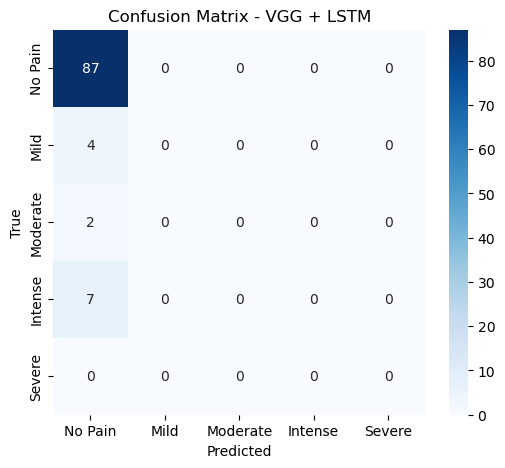

In [104]:
# Predict class probabilities and convert to class indices
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Print classification report
print(classification_report(
    y_test, y_pred,
    labels=[0, 1, 2, 3, 4],
    target_names=["No Pain", "Mild", "Moderate", "Intense", "Severe"]
))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=["No Pain", "Mild", "Moderate", "Intense", "Severe"],
            yticklabels=["No Pain", "Mild", "Moderate", "Intense", "Severe"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - VGG + LSTM')
plt.show()

# Working on the RadBoud dataset

In [19]:
# Path to dataset
dataset_dir = '/Users/nadeembaqaeen/Desktop/MSc Project/radboud_dataset'

In [21]:
# Define emotion labels
emotion_labels = {
    "angry": 0,
    "contemptuous": 1,
    "disgusted": 2,
    "fearful": 3,
    "happy": 4,
    "neutral": 5,
    "sad": 6,
    "surprised": 7
}

In [23]:
# Load and preprocess images
X = []
y = []

for filename in os.listdir(dataset_dir):
    if filename.endswith(".jpg"):
        filepath = os.path.join(dataset_dir, filename)
        img = load_img(filepath, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
        X.append(img_array)

        found = False
        for emotion in emotion_labels:
            if emotion in filename.lower():
                y.append(emotion_labels[emotion])
                found = True
                break
        if not found:
            print(f"Skipping {filename}: No emotion found")

X = np.array(X)
y = np.array(y)

In [25]:
# Ensure data exists
if len(X) == 0 or len(y) == 0:
    raise ValueError("No images or labels were loaded. Check your dataset path or filename structure.")

In [27]:
# One-hot encoding
y_cat = to_categorical(y, num_classes=len(emotion_labels))

In [29]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)

In [31]:
# Extract features with ResNet50
resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
resnet.trainable = False

In [33]:
# Wrap ResNet in TimeDistributed
# Simulate a sequence of length 1
model = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(emotion_labels), activation='softmax')
])

In [35]:
# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,312 (91.99 MB)

 Trainable params: 526,600 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [37]:
# Train and prediction
history = model.fit(
    X_train, y_train,
    epochs=10, batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Fine-tune top layers of ResNet for a few more epochs
# Unfreeze last ~50 layers for slight adaptation
for layer in resnet.layers[-50:]:
    layer.trainable = True
model.compile(optimizer=Adam(5e-6), loss='categorical_crossentropy', metrics=['accuracy'])
history_ft = model.fit(
    X_train, y_train,
    epochs=5, batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 117s 963ms/step - accuracy: 0.1405 - loss: 2.2434 - val_accuracy: 0.2179 - val_loss: 2.0589
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 114s 975ms/step - accuracy: 0.1643 - loss: 2.0585 - val_accuracy: 0.2244 - val_loss: 1.9999
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.1926 - loss: 2.0170 - val_accuracy: 0.2521 - val_loss: 1.9434
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.2201 - loss: 1.9369 - val_accuracy: 0.3088 - val_loss: 1.8162
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.2516 - loss: 1.8926 - val_accuracy: 0.2724 - val_loss: 1.8374
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.2626 - loss: 1.8505 - val_accuracy: 0.3654 - val_loss: 1.7216
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.2893 - loss: 1.8191 - val_accuracy: 0.3729 - val_loss: 1.6905
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.2903 - loss: 1.7917 - va

In [128]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 716ms/step


              precision    recall  f1-score   support

       angry       0.27      0.98      0.43       117
contemptuous       0.33      0.12      0.17       117
   disgusted       0.46      0.10      0.17       117
     fearful       0.90      0.22      0.36       117
       happy       0.69      0.95      0.80       117
     neutral       0.50      0.07      0.12       117
         sad       0.44      0.07      0.12       117
   surprised       0.53      1.00      0.69       117

    accuracy                           0.44       936
   macro avg       0.51      0.44      0.36       936
weighted avg       0.51      0.44      0.36       936



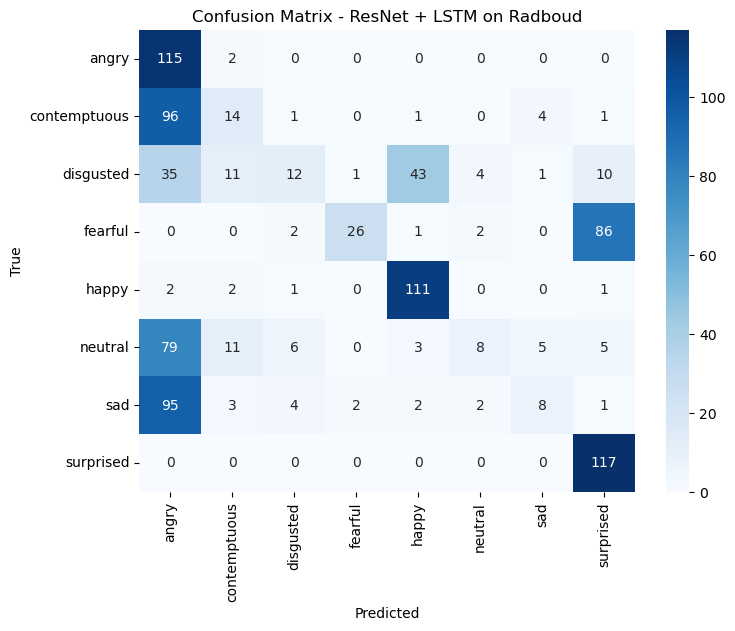

In [129]:
# Evaluation Report and confusion matrix
print(classification_report(y_true, y_pred_classes, target_names=emotion_labels.keys()))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=emotion_labels.keys(), yticklabels=emotion_labels.keys())
plt.title("Confusion Matrix - ResNet + LSTM on Radboud")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Mapping the labels to PSPI scores

In [49]:
images_root = '/Users/nadeembaqaeen/Desktop/MSc Project/Annotations/Pain_Dataset_Images'
pspi_labels_root = '/Users/nadeembaqaeen/Desktop/MSc Project/Annotations/Frame_Labels/PSPI'
out_csv = '/Users/nadeembaqaeen/Desktop/MSc Project/unbc_pspi_to_rafd_labels.csv'

In [51]:
# Map PSPI (0..15)
def map_pspi_to_rafd(pspi):
    p = float(pspi)
    if p == 0:
        return "happy"
    elif p <= 2:
        return "neutral"
    elif p <= 4:
        return "sad"
    elif p <= 6:
        return "fearful"
    elif p <= 8:
        return "disgusted"
    elif p<= 10:
        return "surprised"
    elif p<= 12:
        return "contemptuous"
    else:
        return "angry"

In [53]:
def collect_images(images_root):
    return glob.glob(os.path.join(images_root, '**', '*.png'), recursive=True)

In [55]:
def pspi_path_for_image(img_path):
    """
    UNBC layout per README:
      Images/<subject>/<sequence>/<frame>.png
      PSPI  /<subject>/<sequence>/<frame>_facs.txt
    """
    rel = os.path.relpath(img_path, images_root)
    parts = rel.split(os.sep)
    if len(parts) != 3:
        return None  # unexpected layout
    subject_id, sequence_id, filename = parts
    labelfile = filename.replace('.png', '_facs.txt')
    return os.path.join(pspi_labels_root, subject_id, sequence_id, labelfile)

In [57]:
def read_pspi(label_path):
    try:
        with open(label_path, 'r') as f:
            line = f.readline().strip()
            return float(line)
    except Exception:
        return None

In [59]:
image_paths = collect_images(images_root)
print(f"Found {len(image_paths)} images under {images_root}")

Found 48398 images under /Users/nadeembaqaeen/Desktop/MSc Project/Annotations/Pain_Dataset_Images


In [61]:
rows = []
missing = []
bad_read = []

for img in image_paths:
    lpath = pspi_path_for_image(img)
    if (lpath is None) or (not os.path.exists(lpath)):
        missing.append((img, lpath))
        continue
    score = read_pspi(lpath)
    if score is None:
        bad_read.append((img, lpath))
        continue
    rafd = map_pspi_to_rafd(score)
    rows.append((img, lpath, score, rafd))

df = pd.DataFrame(rows, columns=['image_path', 'pspi_file', 'pspi', 'rafd_label'])

print(f"\nMatched frames with valid PSPI: {len(df)}")
print(f"Missing PSPI files: {len(missing)}   |   Unreadable PSPI: {len(bad_read)}")



Matched frames with valid PSPI: 48398
Missing PSPI files: 0   |   Unreadable PSPI: 0


In [63]:
# Helpful diagnostics 
if missing:
    print("\nExample missing matches (first 5):")
    for a, b in missing[:5]:
        print(" image:", a)
        print("  -> expected label:", b)
if bad_read:
    print("\nExample unreadable PSPI files (first 5):")
    for a, b in bad_read[:5]:
        print(" image:", a)
        print("  -> label file:", b)

In [65]:
# Overview of the findings
# saving the new CSV to the folder
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
df.to_csv(out_csv, index=False)
print(f"\nSaved CSV -> {out_csv}")

if 'rafd_label' in df.columns and len(df) > 0:
    print("\nLabel distribution:")
    print(pd.Series(Counter(df['rafd_label'])).sort_values(ascending=False))
else:
    print("\nNo labels created — check the diagnostics above.")


Saved CSV -> /Users/nadeembaqaeen/Desktop/MSc Project/unbc_pspi_to_rafd_labels.csv

Label distribution:
happy           40029
neutral          5260
sad              2214
fearful           512
disgusted         132
contemptuous      124
surprised          99
angry              28
dtype: int64


In [67]:
df.head()

,image_path,pspi_file,pspi,rafd_label
0,/Users/nadeembaqaeen/Desktop/MSc Project/Annot...,/Users/nadeembaqaeen/Desktop/MSc Project/Annot...,0.0,happy
1,/Users/nadeembaqaeen/Desktop/MSc Project/Annot...,/Users/nadeembaqaeen/Desktop/MSc Project/Annot...,0.0,happy
2,/Users/nadeembaqaeen/Desktop/MSc Project/Annot...,/Users/nadeembaqaeen/Desktop/MSc Project/Annot...,0.0,happy
3,/Users/nadeembaqaeen/Desktop/MSc Project/Annot...,/Users/nadeembaqaeen/Desktop/MSc Project/Annot...,0.0,happy
4,/Users/nadeembaqaeen/Desktop/MSc Project/Annot...,/Users/nadeembaqaeen/Desktop/MSc Project/Annot...,0.0,happy


In [69]:
# Make columns presentation-friendly
# Keep only filename instead of full image path
# Rename rafd_label to label
# Keep only desired columns in order
df_present = df.copy()
df_present['image'] = df_present['image_path'].apply(lambda x: os.path.basename(x))
df_present.rename(columns={'rafd_label': 'label'}, inplace=True)
df_present = df_present[['image', 'pspi', 'label']]
print(df_present.head(10))

                 image  pspi    label
0  ak064t1aaaff060.png   0.0    happy
1  ak064t1aaaff074.png   0.0    happy
2  ak064t1aaaff048.png   0.0    happy
3  ak064t1aaaff262.png   0.0    happy
4  ak064t1aaaff276.png   0.0    happy
5  ak064t1aaaff289.png   6.0  fearful
6  ak064t1aaaff316.png   0.0    happy
7  ak064t1aaaff302.png   0.0    happy
8  ak064t1aaaff114.png   0.0    happy
9  ak064t1aaaff100.png   2.0  neutral


In [71]:
# Number of samples to show
num_samples = 5
sample_df = df_present.sample(num_samples, random_state=42)

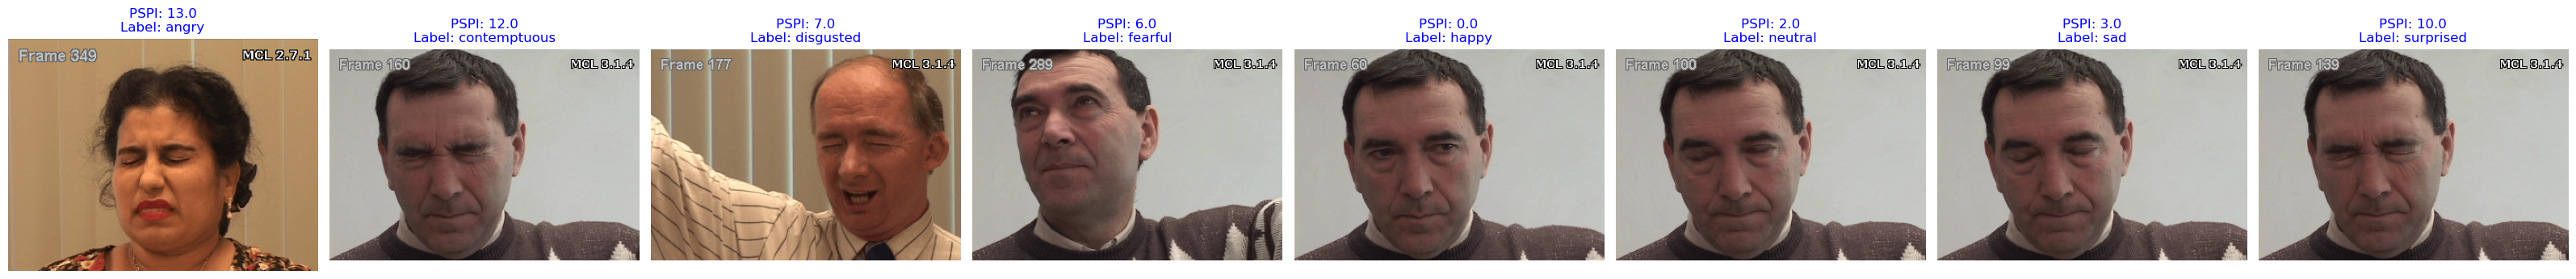

In [79]:
# One image per label
unique_labels_df = df.groupby('rafd_label').first().reset_index()

num_labels = len(unique_labels_df)

plt.figure(figsize=(4*num_labels, 5))
for i, row in enumerate(unique_labels_df.itertuples(), 1):
    img = mpimg.imread(getattr(row, 'image_path'))  # Full path column
    plt.subplot(1, num_labels, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"PSPI: {row.pspi}\nLabel: {row.rafd_label}", fontsize=12, color="blue")

plt.tight_layout()
plt.show()

/var/folders/tn/v3nnb5yx32l6ft01frr725jh0000gn/T/ipykernel_4348/3922281483.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df.groupby('rafd_label').apply(lambda x: x.sample(1)).reset_index(drop=True)


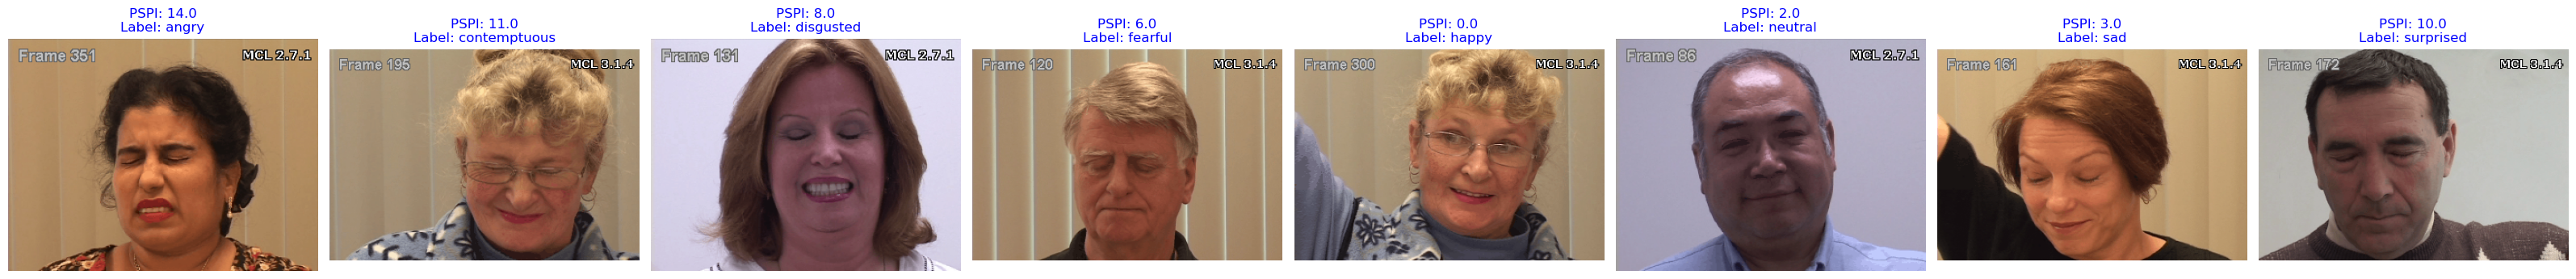

In [75]:
# One random sample per emotion label
sample_df = df.groupby('rafd_label').apply(lambda x: x.sample(1)).reset_index(drop=True)

num_samples = len(sample_df)

plt.figure(figsize=(4*num_samples, 5))
for i, row in enumerate(sample_df.itertuples(), 1):
    img = mpimg.imread(getattr(row, 'image_path'))
    plt.subplot(1, num_samples, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"PSPI: {row.pspi}\nLabel: {row.rafd_label}", fontsize=12, color="blue")

plt.tight_layout()
plt.show()